### Installing neccessary packages:

In [ ]:
!pip install transformers
# https://huggingface.co/transformers/installation.html
!pip install sentencepiece
# https://pypi.org/project/sentencepiece/
# Python wrapper for SentencePiece. This API will offer the encoding, decoding and training of Sentencepiece.
!pip install Cython
# https://pypi.org/project/Cython/

     |████████████████████████████████| 3.1 MB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 33.9 MB/s 
     |████████████████████████████████| 61 kB 442 kB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
     |████████████████████████████████| 895 kB 35.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


## Checking the GPU availabilty

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the required packages:

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import os
import sys
from transformers.optimization import Adafactor 
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import torch
import random
import re

os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP_Final_Project')

In [ ]:
import pandas as pd
# Reading csv
data = pd.read_csv('data_10e_full_v1.csv')
print(data.head(5))

                                              inputs  ... sumlen
0  The sum of 1 10e3 4 10e2 0 10e1 6 10e0 and 7 1...  ...      4
1  The sum of 1 10e3 6 10e2 1 10e1 6 10e0 and 1 1...  ...      4
2  The sum of 3 10e2 7 10e1 6 10e0 and 1 10e3 6 1...  ...      4
3  The sum of 1 10e3 0 10e2 3 10e1 1 10e0 and 4 1...  ...      4
4  The sum of 1 10e3 3 10e2 6 10e1 3 10e0 and 5 1...  ...      4

[5 rows x 5 columns]


In [ ]:
data.info

<bound method DataFrame.info of                                                   inputs  ... sumlen
0      The sum of 1 10e3 4 10e2 0 10e1 6 10e0 and 7 1...  ...      4
1      The sum of 1 10e3 6 10e2 1 10e1 6 10e0 and 1 1...  ...      4
2      The sum of 3 10e2 7 10e1 6 10e0 and 1 10e3 6 1...  ...      4
3      The sum of 1 10e3 0 10e2 3 10e1 1 10e0 and 4 1...  ...      4
4      The sum of 1 10e3 3 10e2 6 10e1 3 10e0 and 5 1...  ...      4
...                                                  ...  ...    ...
14964  The sum of 9 10e2 8 10e1 1 10e0 and 6 10e2 9 1...  ...      4
14965  The sum of 1 10e3 3 10e2 0 10e1 0 10e0 and 6 1...  ...      4
14966  The sum of 1 10e3 6 10e2 6 10e1 0 10e0 and 8 1...  ...      4
14967  The sum of 5 10e2 7 10e1 3 10e0 and 1 10e3 0 1...  ...      4
14968  The sum of 4 10e2 9 10e1 6 10e0 and 1 10e3 7 1...  ...      4

[14969 rows x 5 columns]>

In [ ]:
data = data.sample(n = 14900, random_state = 42).reset_index(drop=True)
len(data)

14900

In [ ]:
from sklearn.model_selection import train_test_split

# Test and validation split
train, validation = train_test_split(data, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size=0.3, random_state=42)

data_train = train.reset_index(drop=True)
data_valid = validation.reset_index(drop=True)
data_test = test.reset_index(drop=True)

In [ ]:
data_train.shape

(8344, 5)

In [ ]:
data_valid.shape

(2980, 5)

In [ ]:
data_test.shape

(3576, 5)

In [ ]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 32
num_of_batches = int(len(data_train)/batch_size)

In [ ]:
# Reference
# https://huggingface.co/transformers/model_doc/t5.html
# https://medium.com/analytics-vidhya/t5-a-detailed-explanation-a0ac9bc53e51
# https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

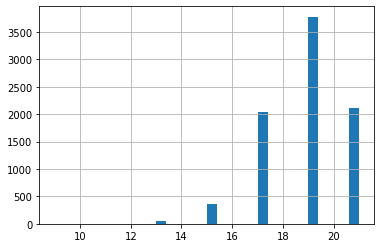

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# T5-base
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
# moving the model to device(GPU/CPU)
model.to(device)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
token_lens = []

for txt in data_train.inputs:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

max(token_lens)

42

In [ ]:
token_lens_target = []

for txt in data_train.target:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_target.append(len(tokens))

max(token_lens_target)

20

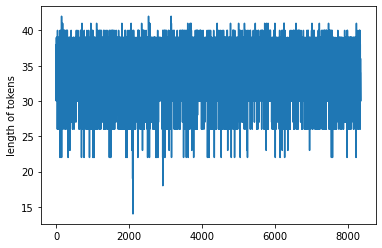

Maximum length is:  42


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 14

In [ ]:
MAX_LEN = 45

In [ ]:
def get_word_embeddings(data, MAX_LEN=45):
  input_ids=[]
  attention_masks = []
  for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = get_word_embeddings(data_train['inputs'])
val_inputs, val_masks = get_word_embeddings(data_valid['inputs'])
test_inputs, test_masks = get_word_embeddings(data_test['inputs'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
data_train['target_str'] = data_train['target'].astype(str)
data_valid['target_str'] = data_valid['target'].astype(str)
data_test['target_str'] = data_test['target'].astype(str)

In [ ]:
#convert lists to tensors
train_labels = get_word_embeddings(data_train['target_str'], 25)[0]
val_labels = get_word_embeddings(data_valid['target_str'], 25)[0]
test_labels = get_word_embeddings(data_test['target_str'], 25)[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_labels.shape
# doubt

torch.Size([8344, 25])

In [ ]:
train_labels

tensor([[209, 335,  15,  ...,   0,   0,   0],
        [668, 335,  15,  ...,   0,   0,   0],
        [209, 335,  15,  ...,   0,   0,   0],
        ...,
        [209, 335,  15,  ...,   0,   0,   0],
        [204, 335,  15,  ...,   0,   0,   0],
        [209, 335,  15,  ...,   0,   0,   0]])

In [ ]:
data_train['target']

0       1 10e3 4 10e2 8 10e1 3 10e0
1              9 10e2 3 10e1 5 10e0
2       1 10e3 3 10e2 6 10e1 4 10e0
3       1 10e3 3 10e2 7 10e1 6 10e0
4       1 10e3 7 10e2 5 10e1 9 10e0
                   ...             
8339    1 10e3 4 10e2 7 10e1 8 10e0
8340    2 10e3 2 10e2 7 10e1 8 10e0
8341    1 10e3 2 10e2 2 10e1 5 10e0
8342    2 10e3 3 10e2 8 10e1 4 10e0
8343    1 10e3 5 10e2 5 10e1 7 10e0
Name: target, Length: 8344, dtype: object

In [ ]:
train_inputs.shape

torch.Size([8344, 45])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [ ]:
#  Optimizer
# https://huggingface.co/transformers/model_doc/t5.html#overview
optimizer = Adafactor(
    model.parameters(),
    lr=3e-4, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.5,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/MyDrive/Colab Notebooks/new_run')
# print(os.getcwd())

In [ ]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2021-12-04 15:21:33--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.39.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.39.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json.6’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-12-04 15:21:34 (30.3 MB/s) - ‘t5-base-config.json.6’ saved [1199/1199]



In [ ]:
from IPython.display import HTML, display

# Setting the progress, with html as UI.
def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    v_accuracy = []
    v_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        
        v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in batch)

        # print(v_input_ids.shape, v_labels.shape)

        val_outputs = model.generate(input_ids=v_input_ids, attention_mask=v_attn_mask)

        val_preds = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in val_outputs]

        val_labels = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in v_labels]
        
        # v_loss.append(val_outputs.loss)

        # Get the predictions
        # print(val_outputs.logits.shape)
        # val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        # print(val_preds, val_labels)
        # Calculate the accuracy rate

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        accuracy = ((val_preds == val_labels).sum() / len(val_labels)) * 100
        v_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    # v_loss = np.mean(v_loss)
    v_accuracy = np.mean(v_accuracy)

    return v_accuracy

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  running_loss=0
  # out = display(progress(1, num_of_batches+1), display_id=True)
  i =0 
  for batch in train_dataloader:
    
    input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()
    gc.collect()
    torch.cuda.empty_cache()

    # Forward propogation
    # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
    outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
    
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    # out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    # updating the params
    optimizer.step()

    print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
    i += 1

  running_loss = running_loss/len(train_dataloader)
  # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
  curr_accuracy = evaluate(model, val_dataloader)

  # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
  print("-"*70)

  if curr_accuracy > val_acc:
    val_acc = curr_accuracy
    # Saving the best model
    torch.save(model.state_dict(),'FineTune_10e_Model_32eph_5e_4_v3322.bin')


Running epoch: 1
Epoch  1 Batch  0 / 261  Training Loss  7.266964912414551
Epoch  1 Batch  1 / 261  Training Loss  2.8265485763549805
Epoch  1 Batch  2 / 261  Training Loss  1.3468682765960693
Epoch  1 Batch  3 / 261  Training Loss  1.0255646705627441
Epoch  1 Batch  4 / 261  Training Loss  0.966743528842926
Epoch  1 Batch  5 / 261  Training Loss  1.2884800434112549
Epoch  1 Batch  6 / 261  Training Loss  0.6770210862159729
Epoch  1 Batch  7 / 261  Training Loss  0.5691906213760376
Epoch  1 Batch  8 / 261  Training Loss  0.5051558017730713
Epoch  1 Batch  9 / 261  Training Loss  0.4489794075489044
Epoch  1 Batch  10 / 261  Training Loss  0.41639935970306396
Epoch  1 Batch  11 / 261  Training Loss  0.40877223014831543
Epoch  1 Batch  12 / 261  Training Loss  0.41290661692619324
Epoch  1 Batch  13 / 261  Training Loss  0.39036670327186584
Epoch  1 Batch  14 / 261  Training Loss  0.3921063542366028
Epoch  1 Batch  15 / 261  Training Loss  0.38539278507232666
Epoch  1 Batch  16 / 261  Trai

In [ ]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/My Drive/Colab Notebooks/new/')

# print(os.getcwd())

#### Saving the Model (creating checkpoint)

In [ ]:
# PATH = "fine_tune_10e_20eph.pt"
# torch.save({
#             'epoch': num_of_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': running_loss,
#             }, PATH)

In [ ]:
model_load = T5ForConditionalGeneration.from_pretrained('FineTune_10e_Model_32eph_5e_4_v3322.bin', return_dict=True, config='t5-base-config.json')

In [ ]:
model_load.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
# Function to generate sentences from symptoms on the test dataset
def generateText(text):
  model_load.eval()
  input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
  # s = time.time()
  outputs = model_load.generate(input_ids)
  prediction=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  return prediction

In [ ]:
data_ood = pd.read_csv('data_10e_ood_full.csv')
print(data_ood.head(5))

                                              inputs                              target
0  The sum of 9 10e3 8 10e2 2 10e1 8 10e0 and 2 1...  1 10e4 2 10e3 2 10e2 6 10e1 5 10e0
1  The sum of 3 10e3 9 10e2 0 10e1 4 10e0 and 4 1...         8 10e3 1 10e2 0 10e1 4 10e0
2  The sum of 3 10e3 8 10e2 6 10e1 4 10e0 and 2 1...         6 10e3 1 10e2 9 10e1 5 10e0
3  The sum of 2 10e3 1 10e2 7 10e1 6 10e0 and 2 1...         4 10e3 2 10e2 2 10e1 7 10e0
4  The sum of 8 10e3 2 10e2 2 10e1 1 10e0 and 4 1...  1 10e4 2 10e3 8 10e2 0 10e1 0 10e0


In [ ]:
data_ood['type'] = "OOD"

data_test['type'] = 'iid'
data_ood['target_str'] = data_ood['target'].astype(str)

bigdata = data_test.append(data_ood, ignore_index=True)

In [ ]:
bigdata['inputs']
bigdata['predictions'] = bigdata.apply(lambda x: generateText(x['inputs']), axis=1)
bigdata.to_csv('results_infer_10e.csv', index = False, header=None)

In [ ]:
evaluate(model_load, test_dataloader)

99.84270134228188